# Coal prediction in mines 2013
by Bad Wizard  

Abstract: We did a lot of analysis and came to some interesting conclusions.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, r2_score, mean_squared_error

sns.set();

## Cleaned data

We cleaned this data in the notebook stored in: deliver/Data_cleaning.ipynb

In [2]:
df = pd.read_csv('../data/cleaned_coalpublic2013.csv',header=0,index_col='MSHA ID')
df[['Year','Mine_Name']].head()

,Year,Mine_Name
MSHA ID,,
103381,2013,Tacoa Highwall Miner
103404,2013,Reid School Mine
100759,2013,North River #1 Underground Min
103246,2013,Bear Creek
103451,2013,Knight Mine


# Predict the Production of coal mines

In [3]:
features = ['Average_Employees',
            'Labor_Hours',
          ]

categoricals = ['Mine_State',
                'Mine_County',
                'Mine_Status',
                'Mine_Type',
                'Company_Type',
                'Operation_Type',
                'Union_Code',
                'Coal_Supply_Region',
          ]

target = 'log_production'

## first, look at the interplay between each possible predictor and the target variable

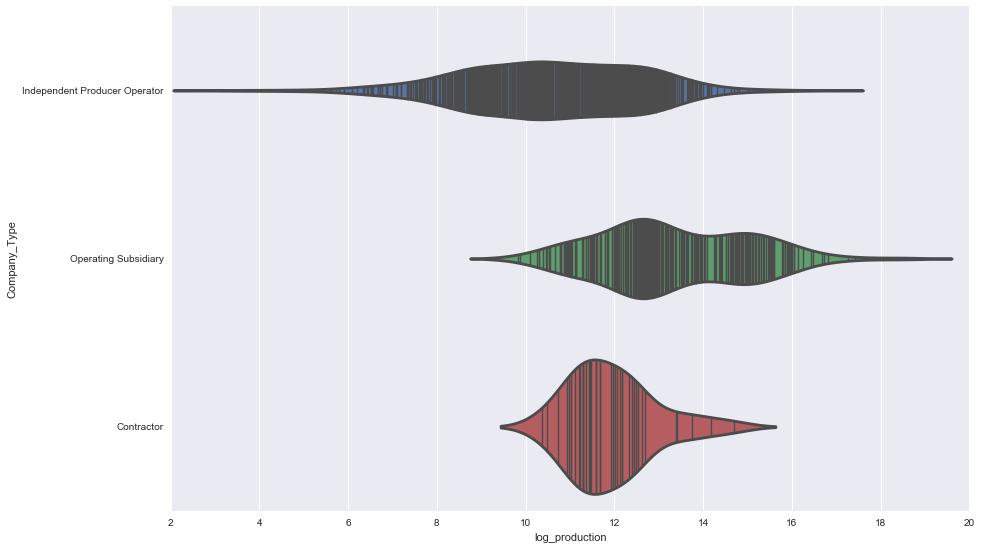

In [4]:
fig = plt.subplots(figsize = (14,8))
sns.set_context('poster')
sns.violinplot(y='Company_Type',x='log_production', data=df,
              split=True, inner = 'stick',)
plt.tight_layout()
plt.savefig("../figures/Coal_prediction_company_type_vs_log_production.png")

In [5]:
dummy_categoricals = []
for categorical in categoricals:
    drop_var = sorted(df[categorical].unique())[-1]
    temp_df = pd.get_dummies(df[categorical],prefix=categorical)
    df = pd.concat([df,temp_df],axis = 1)
    temp_df.drop('_'.join([categorical, str(drop_var)]), axis = 1, inplace = True)
    dummy_categoricals +=temp_df.columns.tolist()

# Random Forest Regressor

In [6]:
train, test = train_test_split(df, test_size = 0.3)

In [7]:
rf = RandomForestRegressor(n_estimators=100, oob_score=True)
rf.fit(train[features + dummy_categoricals], train[target])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=None,
           verbose=0, warm_start=False)

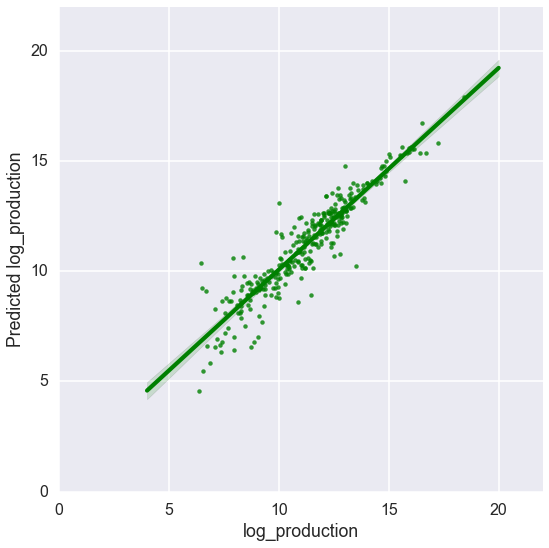

In [8]:
sns.set_context('poster')
fig = plt.subplots(figsize = (8,8))
sns.regplot(test[target],rf.predict(test[features + dummy_categoricals]),color='green')
plt.ylabel('Predicted log_production')
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.tight_layout()
plt.savefig('../figures/Coal-production-RF-prediction.png')

In [9]:
predicted = rf.predict(test[features + dummy_categoricals])
print('R^2 score:',r2_score(test[target], predicted))
print("Explained variance score:", explained_variance_score(test[target], predicted))
print('MSE:', mean_squared_error(test[target], predicted))

R^2 score: 0.860755354661
Explained variance score: 0.861038894694
MSE: 0.68105361528


In [10]:
# find out the relative importance of each feature

rf_importances = pd.DataFrame({'name':train[features + dummy_categoricals].columns,
                              'importance':rf.feature_importances_
                              }).sort_values(by='importance', 
                                             ascending = False).reset_index(drop=True)
rf_importances[:5]

,importance,name
0,0.808339,Labor_Hours
1,0.092907,Average_Employees
2,0.008903,Mine_Type_Surface
3,0.006567,Mine_County_Campbell
4,0.006050,Coal_Supply_Region_Appalachia Central


# Conclusion

Detailed and amazing conclusion